In [313]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer


from scipy import stats
from prettytable import PrettyTable

In [314]:
data = pd.read_csv('data.csv')

Function for scores and ROC curve with corss-validation

In [315]:
def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

In [316]:
class_names = ['Breast Cancer Deaths',
    'COVID-19 Deaths',
    'Cardiovascular Disease Deaths',
    'Diabetes Deaths',
    'Drug Overdose Deaths',
    'Firearm Deaths',
    'HIV-Related Deaths',
    'Heart Disease Deaths',
    'Infant Deaths',
    'Injury Deaths',
    'Lung Cancer Deaths',
    'Maternal Deaths',
    'Motor Vehicle Deaths',
    'Opioid Overdose Deaths',
    'Pneumonia or Influenza Deaths',
    ]

In [317]:
def perso_roc(test, X, y, class_names):
    y_pred_proba_cv = cross_val_predict(test, X, y, cv=15, method='predict_proba')

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y == i).astype(int), y_pred_proba_cv[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - OvR')
    plt.legend(loc='lower right')


Feature Selection for RF

In [318]:
X = data.drop('metric_item_label', axis = 1)
y = data['metric_item_label']

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [320]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, y_train)

importances_RF = RF.feature_importances_
sorted_indices = np.argsort(importances_RF)[::-1]
important_RF_10 = sorted_indices[:15]
improtant_RF_features = X.columns[important_RF_10]


Text(0.5, 1.0, 'Feature Selection using RF for metric_item_label')

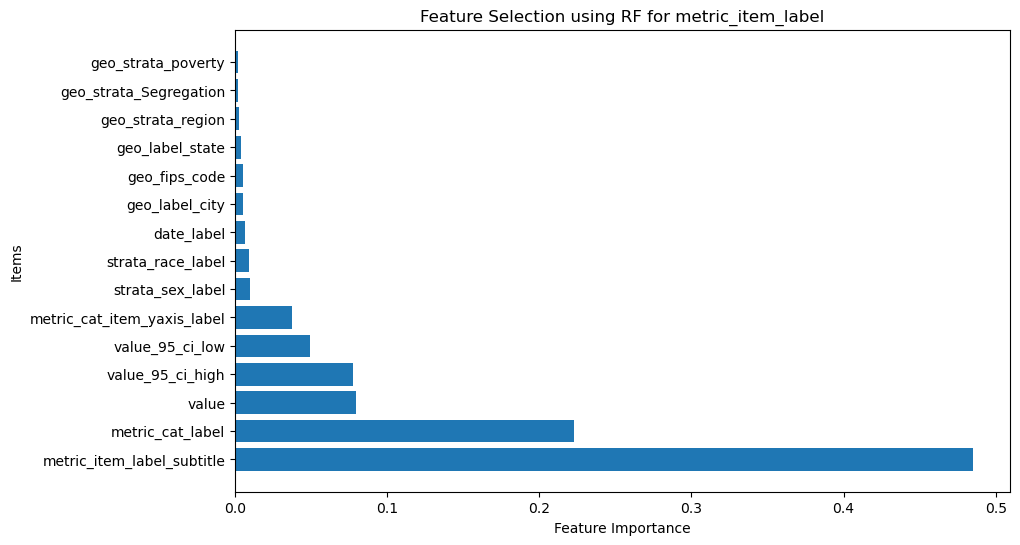

In [321]:
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances_RF[important_RF_10], align='center')
plt.yticks(range(15), improtant_RF_features)
plt.xlabel('Feature Importance')
plt.ylabel('Items')
plt.title('Feature Selection using RF for metric_item_label')

In [322]:
feature_selection_RF = sorted_indices[:8]
feature_selection_RF = X.columns[feature_selection_RF]

feature_selection_RF

Index(['metric_item_label_subtitle', 'metric_cat_label', 'value',
       'value_95_ci_high', 'value_95_ci_low', 'metric_cat_item_yaxis_label',
       'strata_sex_label', 'strata_race_label'],
      dtype='object')

### Random Forest Model

In [323]:
X = data[feature_selection_RF]
y = data['metric_item_label']

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Changing some Hyperparameters

In [325]:
RF = RandomForestClassifier(n_estimators=10, max_depth=8, max_samples=15, class_weight='balanced')
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

In [326]:
y_pred_proba_rf = RF.predict_proba(X_test) 
auc_RF = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')

In [327]:
accuracy_RF, precision_RF, recall_RF, f1_RF = scores(y_test, y_pred_RF)

print(f"Accuracy: {accuracy_RF}")
print(f"Precision: {precision_RF}")
print(f"Recall: {recall_RF}")
print(f"F1 Score: {f1_RF}")

Accuracy: 0.6462
Precision: 0.6577791340702009
Recall: 0.6462
F1 Score: 0.6245967095564177


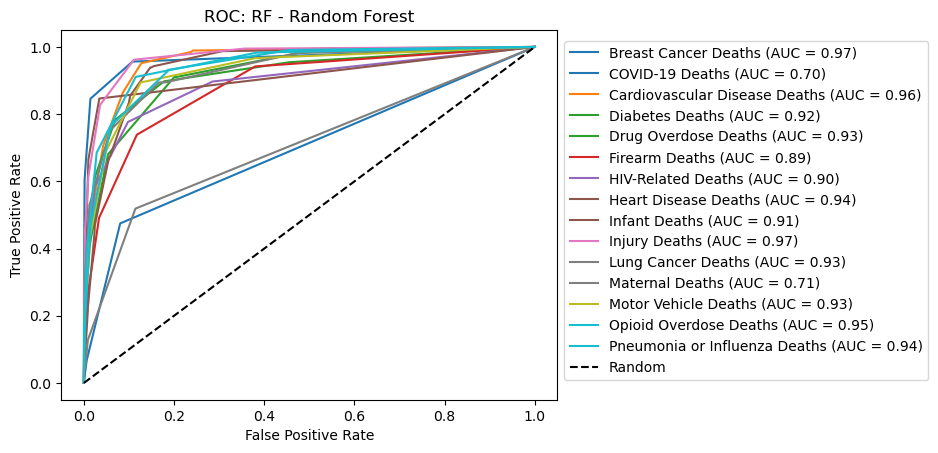

In [328]:
perso_roc(RF, X, y, class_names)
plt.title('ROC: RF - Random Forest')
plt.legend(bbox_to_anchor=(1, .99), loc='upper left')


### Logistic Regression Model

In [329]:
LogReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=8, penalty='l2', class_weight='balanced')

The higher the C, the smaller the overfitting. Saga is used for regularization using L2. 

In [330]:
LogReg.fit(X_train, y_train)
y_pred_LogReg = LogReg.predict(X_test)

In [331]:
y_pred_proba_LR = LogReg.predict_proba(X_test) 
auc_LogReg = roc_auc_score(y_test, y_pred_proba_LR, multi_class='ovr')

In [332]:
accuracy_LogReg, precision_LogReg, recall_LogReg, f1_LogReg = scores(y_test, y_pred_LogReg)

print(f"Accuracy: {accuracy_LogReg}")
print(f"Precision: {precision_LogReg}")
print(f"Recall: {recall_LogReg}")
print(f"F1 Score: {f1_LogReg}")

Accuracy: 0.5714
Precision: 0.5885080783240152
Recall: 0.5714
F1 Score: 0.5507389321054755


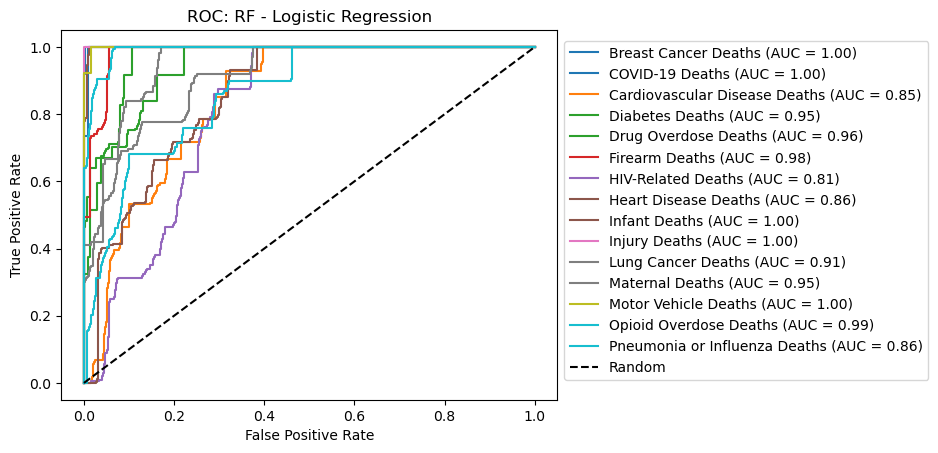

In [333]:
perso_roc(LogReg, X, y, class_names)
plt.title('ROC: RF - Logistic Regression')
plt.legend(bbox_to_anchor=(1, .99), loc='upper left')


### Decision Tree Model

In [334]:
DT = DecisionTreeClassifier(max_depth=4, min_samples_split=40, max_features=2)
DT.fit(X_train ,y_train)

y_pred_DT = DT.predict(X_test)

In [335]:
y_pred_proba_DT = DT.predict_proba(X_test) 
auc_DT = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')

In [336]:
accuracy_DT, precision_DT, recall_DT, f1_DT = scores(y_test, y_pred_DT)

print(f"Accuracy: {accuracy_DT}")
print(f"Precision: {precision_DT}")
print(f"Recall: {recall_DT}")
print(f"F1 Score: {f1_DT}")

Accuracy: 0.5464
Precision: 0.4448655055091674
Recall: 0.5464
F1 Score: 0.4474517989183682


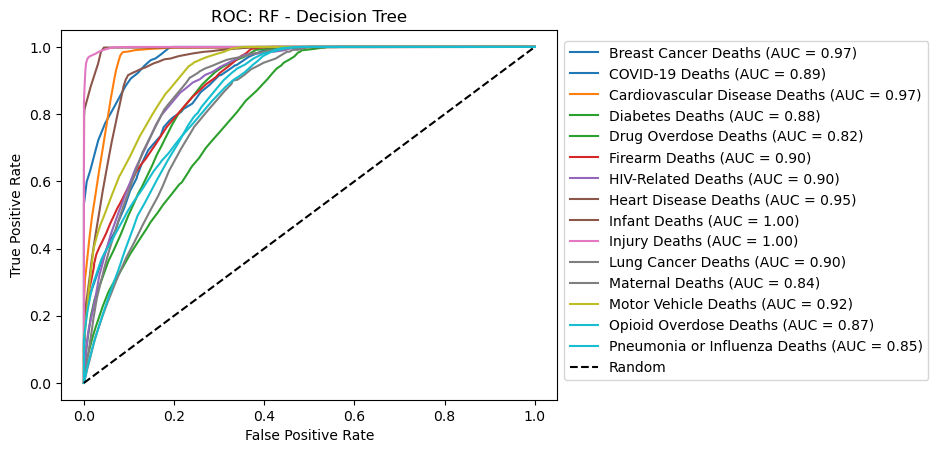

In [337]:
perso_roc(DT, X, y, class_names)
plt.title('ROC: RF - Decision Tree')
plt.legend(bbox_to_anchor=(1, .99), loc='upper left')


### Using KNN model

In [338]:
knn = KNeighborsClassifier(n_neighbors=7000, algorithm='ball_tree')

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test) 

auc_knn = roc_auc_score(y_test, y_pred_proba_knn, multi_class='ovr')


In [339]:
accuracy_knn, precision_knn, recall_knn, f1_knn = scores(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")


Accuracy: 0.469
Precision: 0.31226174446741395
Recall: 0.469
F1 Score: 0.3587814649377599


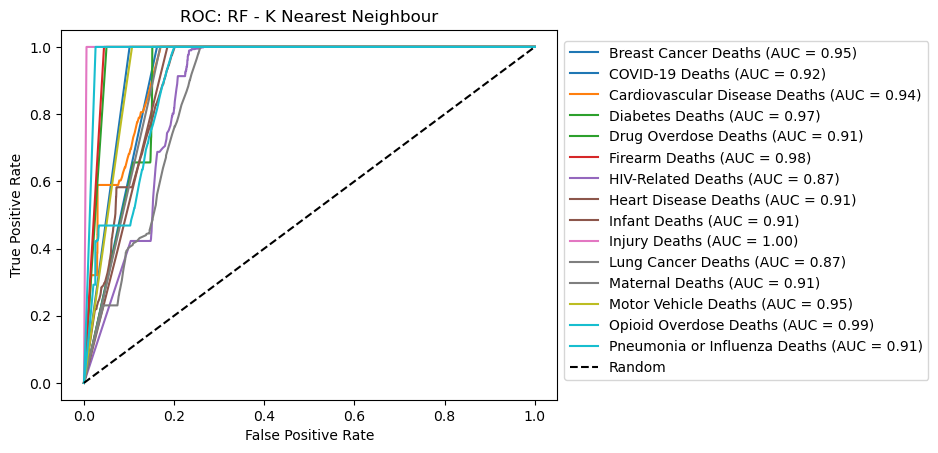

In [340]:
perso_roc(knn, X, y, class_names)
plt.title('ROC: RF - K Nearest Neighbour')
plt.legend(bbox_to_anchor=(1, .99), loc='upper left')


### Scores

In [341]:
model_names = ['RF', 'LogReg', 'KNN', 'DT']
accuracy_scores = [accuracy_RF, accuracy_LogReg, accuracy_knn, accuracy_DT]
precision_scores = [precision_RF, precision_LogReg, precision_knn, precision_DT]
recall_scores = [recall_RF, recall_LogReg, recall_knn, recall_DT]
f1_scores = [f1_RF, f1_LogReg, f1_knn, f1_DT]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

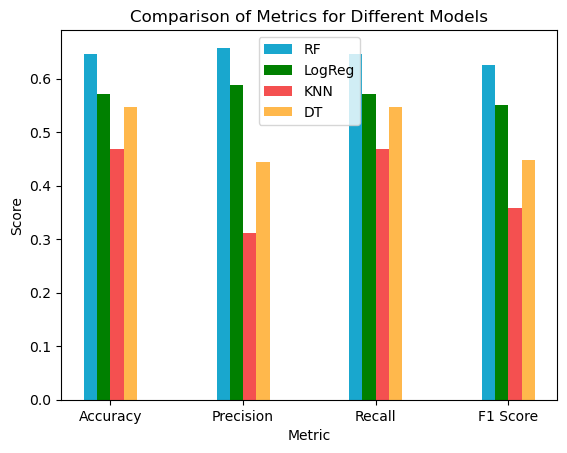

In [342]:
x = np.arange(len(metric_names))

bar_width = 0.1

color_map = {'RF': '#19A7CE', 'LogReg': 'green', 'KNN': '#F45050', 'DT': '#FFB84C'}

fig, ax = plt.subplots()

for i, model_name in enumerate(model_names):
    model_scores = [accuracy_scores[i], precision_scores[i], recall_scores[i], f1_scores[i]]
    bar_positions = x + (i * bar_width)
    ax.bar(bar_positions, model_scores, bar_width, label=model_name, color=color_map[model_name])

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics for Different Models')
ax.set_xticks(x + (bar_width * 1.5))
ax.set_xticklabels(metric_names)
ax.legend()

Random Forest AUC: 0.9332878394109804
Decision Tree AUC: 0.9119362652965151
Logistic Regression AUC: 0.9437669791493537
KNN AUC: 0.9182576774117205


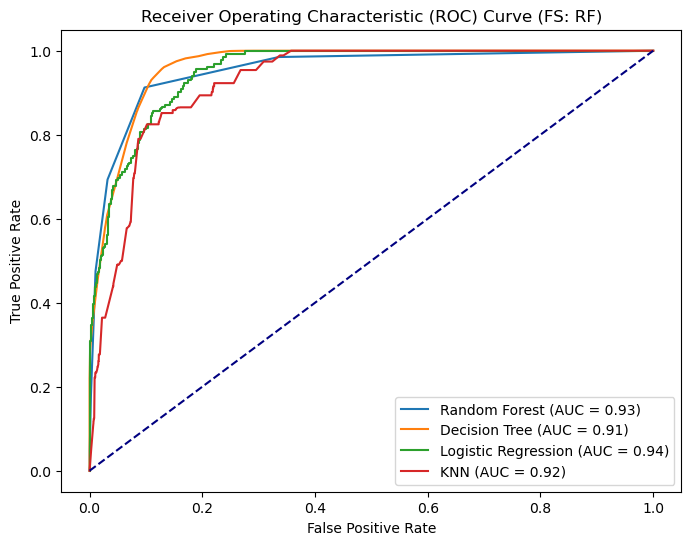

In [343]:
# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_proba_rf.ravel())
print(f"Random Forest AUC: {auc_RF}")

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_proba_DT.ravel())
print(f"Decision Tree AUC: {auc_DT}")

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_proba_LR.ravel())
print(f"Logistic Regression AUC: {auc_LogReg}")

# SVC
fpr_knn, tpr_knn, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_proba_knn.ravel())
print(f"KNN AUC: {auc_knn}")


# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_RF:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_DT:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_LogReg:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (FS: RF)')
plt.legend(loc='lower right')
